In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from pdb import set_trace

### Data processing

In [4]:
# load training dataset
train = pd.read_csv('krug_train_0425.csv')
print("Shape:", train.shape)

Shape: (7700, 254)


In [5]:
# excluding "unclassified" gene
train = train[train['Localization']!='Unclassified']
print("Shape:", train.shape)

Shape: (7167, 254)


In [6]:
# check target class and number
Counter(train['Localization'])

Counter({'Cytosol': 3068,
         'Secretory': 1602,
         'Mitochondria': 508,
         'Nuclear': 1989})

In [7]:
train.drop(columns=['Unnamed: 0','Gene'],inplace=True)

In [8]:
# assign independent variables as X and target as Y
X = train.drop(columns='Localization')
Y = train['Localization']

In [9]:
X

,CPT000814_mrna,CPT000814_prot,CPT001846_mrna,CPT001846_prot,Hydropathicity,Hydrophobic,Length,Mass,Negative Charged,Polar,...,X21BR001_mrna,X21BR001_prot,X21BR002_mrna,X21BR002_prot,X21BR010_mrna,X21BR010_prot,X22BR005_mrna,X22BR005_prot,X22BR006_mrna,X22BR006_prot
0,0.096662,-0.987411,0.963136,0.510677,-107.2,253,495,54254,59,123,...,0.220329,-0.980020,-2.368934,-1.496265,-1.030711,0.338161,-1.473182,-0.142581,-0.497003,-0.135263
2,1.807365,1.661429,-1.073807,-0.544436,-229.2,694,1454,161107,147,469,...,-1.064193,-0.478182,-1.748910,-0.505438,-0.380101,-0.723629,0.159810,-1.589012,-0.752751,-1.208401
3,0.921069,2.207973,0.149664,1.134415,-45.9,281,546,59574,44,159,...,1.795527,1.926580,1.847351,0.904696,-1.521417,-0.457078,0.142118,0.307630,1.043184,0.946137
4,0.545107,-0.245457,-0.996630,-0.604077,-101.0,332,672,75144,81,173,...,0.622088,-0.582726,0.932254,-1.483978,-2.739788,-0.819272,-0.259954,-0.198655,0.065907,-0.024713
5,1.629199,NaN,1.132385,NaN,-56.3,219,425,47352,43,114,...,-1.523778,NaN,-0.867375,NaN,-0.245352,-0.381538,-0.988437,-0.966856,-0.323424,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7695,3.211827,-1.628449,-0.059647,-1.627513,-352.3,435,858,89988,76,231,...,2.775597,2.207727,3.158407,-0.137500,-0.027997,-1.499737,-1.275230,1.302235,-0.259425,1.094237
7696,-1.569251,1.409412,0.181830,0.078361,-52.9,354,744,83921,82,205,...,-1.139624,0.545419,-0.709049,0.729573,1.276216,0.044586,-0.453202,-1.780543,2.019090,-0.274506
7697,1.101153,-1.176195,2.392994,2.096937,-360.6,298,572,61277,55,155,...,0.649147,-1.069202,1.366297,-0.015496,-1.157026,0.212588,-1.024858,-0.008350,-2.017560,2.044309
7698,0.456382,-2.011132,-0.510165,-0.237296,-699.0,1359,2961,331075,384,826,...,2.183494,2.197884,1.692770,0.630830,-1.225778,0.084463,-0.924131,-0.376934,-6.868664,2.309742


In [10]:
# encode target
Y = LabelEncoder().fit_transform(Y)

In [11]:
# sanity check to see numbers match and matching with previous counter to create target dictionary
print(Counter(train['Localization']))
print(Counter(Y))
target_dict = {'Cytosol':0, 'Mitochondria':1, 'Nuclear':2, 'Secretory':3, 'Unclassified':4}

Counter({'Cytosol': 3068, 'Nuclear': 1989, 'Secretory': 1602, 'Mitochondria': 508})
Counter({0: 3068, 2: 1989, 3: 1602, 1: 508})


In [12]:
# train-valid split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.30, random_state=0)

In [13]:
for i in [X_train, X_val, y_train, y_val]:
    print(len(i))

5016
2151
5016
2151


### Customized Pytorch Dataset class

In [15]:
# Pytorch dataset
class LoadingDataset(Dataset):
    
    def __init__(self, X, Y):
        """
        X is the independent variable
        Y is the encoded target
        """
        X = X.copy()
        self.X = X.values.astype(np.float32)
        self.y = Y
        
    def __len__(self):
        return len(self.y) # return number of rows in dependent variable
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
# creating train and valid datasets
train_datasets = LoadingDataset(X_train, y_train)
valid_datasets = LoadingDataset(X_val, y_val)

### Devices (GPU/CPU)

In [17]:
# making GPU and CPU compatiable
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

### Model

In [21]:
class CNN(nn.Module):
    
    def __init__(self, n_cont):
        super().__init__()
        self.n_cont = n_cont
        self.lin1 = nn.Linear(self.n_cont, 128)
        self.lin2 = nn.Linear(128, 32)
        self.lin3 = nn.Linear(32, 4)
        #self.bn1 = nn.BatchNorm1d(self.n_cont)
        #self.bn2 = nn.BatchNorm1d(100)
        #self.bn3 = nn.BatchNorm1d(50)
        #self.drops = nn.Dropout(0.3)
        
    def forward(self, x):
        #x = self.bn1(x_cont)
        x = F.relu(self.lin1(x))
        #x = self.drops(x)
        #x = self.bn2(x)
        x = F.relu(self.lin2(x))
        #x = self.drops(x)
        #x = self.bn3(x)
        x = self.lin3(x)
        
        return x

In [22]:
model = CNN(n_cont=len(X.columns))
to_device(model, device)

CNN(
  (lin1): Linear(in_features=251, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=4, bias=True)
)

### Optimizer

In [23]:
def get_optimizer(model, lr, wd):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = op.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

### Training function

In [24]:
def train_loss(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)
        loss = F.cross_entropy(output, y)    #loss function
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

### Evaluation function

In [25]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    return sum_loss/total, correct/total

### Training loop

In [29]:
def train_loop(model, epochs, lr, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    
    times_trained = list(range(epochs))
    train_loss_list = []
    accuracy = []
    valid_loss_list = []
    
    for i in range(epochs): 
        loss = train_loss(model, optim, train_dl)
        train_loss_list.append(loss)
        print(f"Epoch {i}, training loss: ", loss)
        valid_loss, accur = val_loss(model, valid_dl)
        print("valid loss %.3f and accuracy %.3f" % (valid_loss, accur))
        valid_loss_list.append(valid_loss)
        accuracy.append(accur)
    
    # visualize
    plt.subplot(2, 1, 1)
    plt.plot(times_trained, train_loss_list, label='Training loss') 
    plt.plot(times_trained, valid_loss_list, label='Validation loss')
    #plt.xlabel('Epochs')
    plt.ylabel("Training & Validation loss")
    
    plt.subplot(2, 1, 2)
    plt.plot(times_trained, accuracy, label='Accuracy')  
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.show()

### Training

In [30]:
batch_size = 64
train_dl = DataLoader(train_datasets, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_datasets, batch_size=batch_size,shuffle=True)

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Epoch 0, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 1, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 2, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 3, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 4, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 5, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 6, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 7, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 8, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 9, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 10, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 11, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 12, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 13, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 14, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 15, training loss:  nan
valid loss nan and a

Epoch 128, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 129, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 130, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 131, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 132, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 133, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 134, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 135, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 136, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 137, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 138, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 139, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 140, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 141, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 142, training loss:  nan
valid loss nan and accuracy 0.437
Epoch 143, training loss:

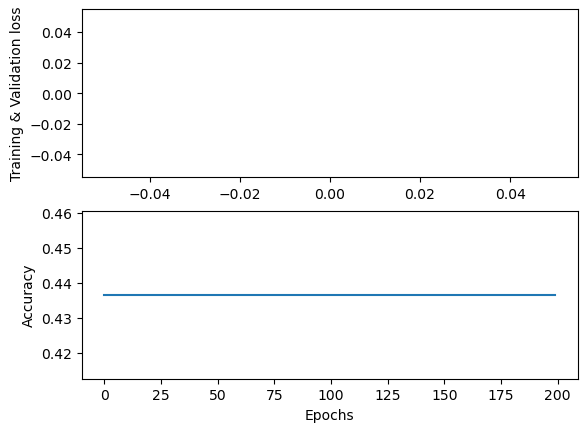

In [32]:
train_loop(model, epochs=200, lr=3e-4, wd=0.0001)

### Evaluation WIP

In [ ]:
# with torch.no_grad():
#     model.eval()
#     output = model.forward(y_).cuda()
# output

### Visualization

In [ ]:
def confusio_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(8,4))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Cytosol', 'Mitochondria', 'Nuclear', 'Secretory']
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  
  for i in range(4):
      for j in range(4):
          plt.text(j,i,str(cm[i][j]))
  plt.show()

In [ ]:
#confusio_matrix(y_val, predicted)